# Lecture 6 Demo: Superdense Coding and Teleportation

In this demo, we will cover the 2 quantum communication protocols covered in lecture 6, namely superdense coding and teleportation. These two quantum information theoretic protocols are complementary of each other. The goal of superdense coding is to send 2 classical bits with 1 qubit, while the goal of teleportation is to send 1 qubit with 2 classical bits. These communication protocols are the first to demonstrate the power of quantum computation.


| Superdense Coding                                    | Teleportation                                     |
|:----------------------------------------------------:|:-------------------------------------------------:|
| Transmit two<br>classical bits<br>using one<br>qubit | Transmit one<br>qubit using two<br>classical bits |

## Import Necessary Packages

In [1]:
import qiskit

In [2]:
from qiskit import *
from qiskit.visualization import plot_histogram

## Superdense Coding
In Superdense Coding, the goal is to try to send 2 classical bits with 1 quantum bit with the use of a Bell pair. Hence, the 3 stages of the protocol are given below:
    1. Preparation and sharing
    2. Encoding and sending
    3. Decoding
Suppose Alice wants to send Bob two classical bits by sending one qubit, given that they share an entangled pair. The idea is that Alice can apply certain local unitaries to her share of the entangled pair to encode the desired message. Then she can send her qubit to Bob and by performing a measurement on the pair of qubits, Bob can then decode the message. 

### 1. Preparation and sharing
Suppose the two party, Alice and Bob start with a shared Bell pair prepared by a third party, Charlie, with the following function:

In [3]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b)

def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

Each qubit of the resultant state $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$ is then distributed to Alice and Bob so that they share an entangled pair.  


### 2. Encoding and sending
Now Alice encode her 2-bit message by apply a certain local unitary on her qubit according to the encoding rule given below:


| Intended Message | Applied Gate | Resulting State ($\cdot\sqrt{2}$)|
|:----------------:|:------------:|:--------------------------------:|
|00                |$I$           | $|00\rangle + |11\rangle$        |
|10                |$X$           | $|01\rangle + |10\rangle$        |
|01                |$Z$           | $|00\rangle - |11\rangle$        |
|11                |$ZX$          | $-|01\rangle + |10\rangle$       |


In [4]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

### 3. Encoding and sending
Now Bob is ready to decode Alice's secret message by performing a Bell measurement (aka returning to the computational basis and measuring in the computational basis).

In [5]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

### Put these procedures together!

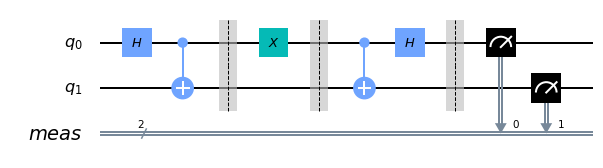

In [6]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw(output = "mpl")

### Simulation

{'10': 1024}


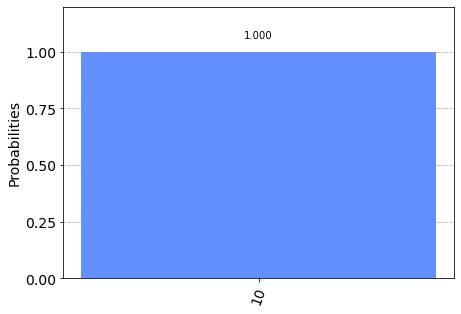

In [7]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

### On a real device...

least busy backend:  ibmq_athens
Job Status: job has successfully run


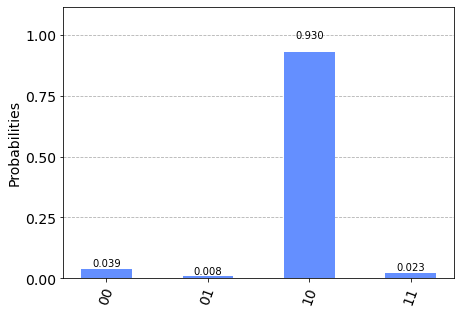

In [8]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 256

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
job = execute(qc, backend=backend, shots=shots)

# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

The accuracy:

In [9]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print("Accuracy = %.2f%%" % accuracy)

Accuracy = 92.97%


# Teleportation

Teleportation is the complementary protocol to superdense coding, where the goal now is to send 1 quantum bit with 2 classical bits, with the help of an entangled pair and a classical channel. 
    1. Preparation and share
    2. Measurement and send
    3. Apply unitary and acquire state
Suppose Alice has a qubit $|\psi\rangle$ that she wants to send to Bob, given that they share an entangled pair. The idea is that Alice performs Bell measurement on the qubit that holds $|\psi\rangle$ and her share of the entangled pair and send the two-bit measurement results to Bob. According to the measurement results, Bob can reconstruct the state $|\psi\rangle$ by applying appropriate unitaries.  

### 1. Preparation and sharing
Suppose the two party, Alice and Bob start with a shared Bell pair prepared by a third party, Charlie, with the following function:

In [10]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b) representing indices of the qubits that Alice and Bob share

def create_bell_pair(qc, a, b):
    qc.h(a) # Apply an h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

Similar to the first step of superdense coding, each qubit of the resultant state $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$ is then distributed to Alice and Bob so that they share an entangled pair.  

### 2. Measurement and send
In this step, Alice performs Bell measurement on the qubit that holds $|\psi\rangle$ and her share of the entangled pair. To perform Bell measurement, one simply reverse the circuit of preparing Bell states. 

In [11]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (psi & a) representing the indices of Alice's qubits 

def bell_measurement(qc, psi, a):
    qc.cx(psi, a) # Apply a CNOT gate, qc(psi) being the control qubit and qc(a) being the target
    qc.h(psi) # Apply an h-gate to qc(psi)
    qc.barrier()
    qc.measure(psi,0)
    qc.measure(a,1)

Alice's measurement results are stored in the two classical registers and then sent to Bob. 

### 3. Apply unitary and acquire state
Now according to the two-bit measurement results, Bob applies a corresponding unitary to reconstruct his state to acquire $|\psi\rangle$. 

In [12]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply

def reconstruction(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

### Put these procedures together!
First, we generate a random state $|\psi\rangle$ for Alice to teleport. 

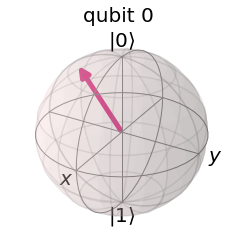

In [13]:
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import random_statevector

# Create random 1-qubit state
psi = random_statevector(2, seed=1)

# Show it on a Bloch sphere
plot_bloch_multivector(psi.data)

Now we set up a gate that intializes Alice's qubit to the state $|\psi\rangle$:

In [14]:
from qiskit.extensions import Initialize
init_gate = Initialize(psi.data)
init_gate.label = "init"

In [15]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
teleportation_circuit.append(init_gate, [0])
teleportation_circuit.barrier()

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
bell_measurement(teleportation_circuit, 0, 1)

## STEP 3
teleportation_circuit.barrier()
reconstruction(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐    ░               
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├────░───────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                             ║  ║       │   ┌──┴──┐
crz_0: ══════════════════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                                ║    ┌──┴──┐└─────┘
crx_0: ═════════════════════════════════════════╩════╡ = 1 ╞═══════
                                                     └─────┘

### Simulation

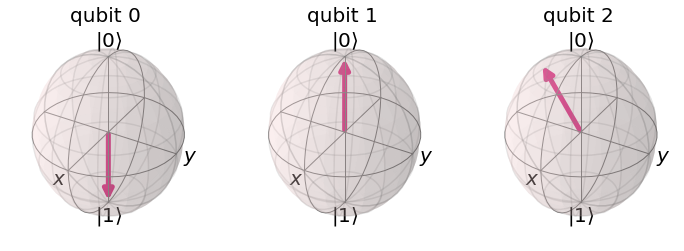

In [16]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(teleportation_circuit, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

# Exercises
Simulate the teleportation circuit with QASM simulator and then try running on the real IBM devices. Refer to https://qiskit.org/textbook/ch-algorithms/teleportation.html#5.1-IBM-hardware-and-Deferred-Measurement- if you have any trouble!